In [1]:
import struct
from struct import unpack
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

device = cuda


In [0]:
import cv2

BASE_SIZE = 256

# Helper from: https://github.com/googlecreativelab/quickdraw-dataset/blob/master/examples/binary_file_parser.py
def unpack_drawing(file_handle, size, lw):
    # Skip key_id: 8, countrycode: 2, recognized: 1, timestamp: 4 = 15
    file_handle.read(15)
    n_strokes, = unpack('H', file_handle.read(2))
    idx = 0

    N = 0
    strokes = []
    for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      N += n_points
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      strokes.append((x, y))

    image = np.zeros((BASE_SIZE, BASE_SIZE, 3), dtype=np.uint8)
    
    # Build the image by drawing the strokes
    for t, (x, y) in enumerate(strokes):
        for i in range(len(x) - 1):
          p1 = (x[i], y[i])
          p2 = (x[i+1], y[i+1])
          cv2.line(image, p1, p2, (255, 255, 255), lw)

    return image if size == BASE_SIZE else cv2.resize(image, (size, size))

def skip_drawing(file_handle):
    # Skip key_id: 8, countrycode: 2, recognized: 1, timestamp: 4 = 15
    file_handle.read(15)
    n_strokes, = unpack('H', file_handle.read(2))
    idx = 0

    N = 0
    strokes = []
    for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      file_handle.read(2 * n_points)


def unpack_drawings(to_skip, filename, size=64, lw=6):
    with open(filename, 'rb') as f:
        for _ in range(to_skip):
          skip_drawing(f)
        while True:
            try:
                yield unpack_drawing(f, size, lw)
            except struct.error:
                break

In [0]:
import urllib.request
from pathlib import Path

urllib.request.urlretrieve('https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt', '100_classes.txt')

# Create data dir
Path("./data").mkdir(exist_ok=True)

In [0]:
f = open("100_classes.txt","r")
# And for reading use
classes = [cls.strip() for cls in f.readlines()]
f.close()

def download(classes):
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
  for i, c in enumerate(classes):
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.bin'
    print((1+i)/len(classes), c, path)
    urllib.request.urlretrieve(path, 'data/'+c+'.bin')

In [5]:
download(classes)

0.01 drums https://storage.googleapis.com/quickdraw_dataset/full/binary/drums.bin
0.02 sun https://storage.googleapis.com/quickdraw_dataset/full/binary/sun.bin
0.03 laptop https://storage.googleapis.com/quickdraw_dataset/full/binary/laptop.bin
0.04 anvil https://storage.googleapis.com/quickdraw_dataset/full/binary/anvil.bin
0.05 baseball_bat https://storage.googleapis.com/quickdraw_dataset/full/binary/baseball%20bat.bin
0.06 ladder https://storage.googleapis.com/quickdraw_dataset/full/binary/ladder.bin
0.07 eyeglasses https://storage.googleapis.com/quickdraw_dataset/full/binary/eyeglasses.bin
0.08 grapes https://storage.googleapis.com/quickdraw_dataset/full/binary/grapes.bin
0.09 book https://storage.googleapis.com/quickdraw_dataset/full/binary/book.bin
0.1 dumbbell https://storage.googleapis.com/quickdraw_dataset/full/binary/dumbbell.bin
0.11 traffic_light https://storage.googleapis.com/quickdraw_dataset/full/binary/traffic%20light.bin
0.12 wristwatch https://storage.googleapis.com/qu

In [6]:
import os

print(len(os.listdir('data')))

100


(2, 64, 64, 3)


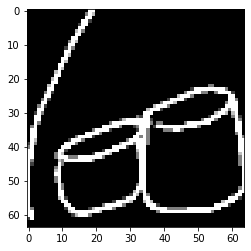

In [7]:
import matplotlib.pyplot as plt

drum_iterator = unpack_drawings(0, "data/drums.bin")
plt.imshow(next(drum_iterator), cmap='gray')

arr = []

arr.append(next(drum_iterator))
arr.append(next(drum_iterator))

print(np.array(arr).shape)

In [0]:
from torch.utils.data import Dataset
from torchvision import transforms

mobilenet_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class DrawDataset(Dataset):
    def __init__(self, X, Y, preprocess):
        self.X = X
        self.Y = Y
        self.preprocess = preprocess

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.preprocess(self.X[idx]), self.Y[idx])

In [0]:
# Config:
batch_size = 256
learning_rate = 0.001

img_size = 64
train_classes = classes[:]


N_train = 8000
N_val = N_train // 5
N_test = 0
# N_test = N_val
N_test_reserved = 20000

n_epochs = 10

In [0]:
from itertools import islice
from torch.nn.utils.rnn import pad_sequence


def extract_dataset(samples_train, samples_val, samples_test, test_reserved, classes, preprocess, img_size=64):
  X_train = []
  X_val = []
  X_test = []
  y_train = []
  y_val = []
  y_test = []

  for c, cls in enumerate(classes):
    drawings = unpack_drawings(test_reserved - samples_train, 'data/' + cls + '.bin', size=img_size)

    # TODO: better way of doing this
    for _ in range(samples_train):
      X_train.append(next(drawings))
      y_train.append(c)

    for _ in range(samples_val):
      X_val.append(next(drawings))
      y_val.append(c)

    for _ in range(samples_test):
      X_test.append(next(drawings))
      y_test.append(c)
  
    
    print(f"\rdone extracting class: {cls}: {1 + c} / {len(classes)}", end='')

    drawings.close()
    

  def norm(X):
    return np.array(X)

  X_train = norm(X_train)
  X_val = norm(X_val)
  X_test = norm(X_test)
  print("training shape", X_train.shape)
  print("validation shape", X_val.shape)
  print("testing shape", X_test.shape)
  print("classes", len(classes))

  return (
      DrawDataset(X_train, torch.LongTensor(y_train), preprocess), 
      DrawDataset(X_val, torch.LongTensor(y_val), preprocess),
      DrawDataset(X_test, torch.LongTensor(y_test), preprocess),
  )

In [0]:
def evaluate_model(model, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    
    for i, (img, label) in enumerate(loader):
      img = img.to(device)
      label = label.to(device)

      out = model(img)

      _, pred = torch.max(out.data, 1)

      total += label.size(0)
      correct += (pred == label).sum().item()

    return 100. * correct / total

In [0]:
import copy
import time

def train_model(model, opt, loss_fn, loader, v_loader, n_epochs):

  best_acc, best_model = 0, None
  losses, accs = [], []
  for epoch in range(n_epochs):
    start = time.time()
    epoch_losses = []
    for i, (img, lab) in enumerate(loader):
      print(f"\rbatch: {i}, current loss: {np.mean(epoch_losses) if epoch_losses else 'NaN'}", end='')
      img = img.to(device)
      lab = lab.to(device)

      out = model(img)

      loss = loss_fn(out, lab)

      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())

    print("\rEvaluating model on validation dataset...", end='')
    val_acc = evaluate_model(model, v_loader)
    mean_loss = np.mean(epoch_losses)

    losses.append(mean_loss)
    accs.append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model = copy.deepcopy(model.state_dict())
      torch.save(best_model, f"lstm_epoch_{epoch}_acc_{val_acc}.model")

    print(f"\rEpoch: {epoch+1}/{n_epochs}, loss: {mean_loss}, validation accuracy: {val_acc}% took: {time.time() - start} seconds")

  print(f"Training ended after {n_epochs} ! Best validation accuracy: {best_acc}%")
 
  return best_model, losses, accs

In [13]:
train_dataset, val_dataset, test_dataset = extract_dataset(N_train, N_val, N_test, N_test_reserved, train_classes, mobilenet_preprocess, img_size)

done extracting class: bicycle: 100 / 100training shape (800000, 64, 64, 3)
validation shape (160000, 64, 64, 3)
testing shape (160000, 64, 64, 3)
classes 100


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
import torch.optim as optim
from torchvision import models

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(
    in_features=model.classifier[1].in_features,
    out_features=len(train_classes), 
    bias=True
)

model.to(device) # puts model on GPU / CPU
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
best_model, losses, accs = train_model(model, optimizer, loss_function, train_loader, val_loader, n_epochs)

batch: 1600, current loss: 0.853685634471476